First, we process magic cards from modern sets in the magic.json database.

In [202]:
import json
magic_json = json.load(open('AllSets.json','rb'))

def to_triple(s):
    return tuple(map(int, s.split('-')))

def cleanup(s):
    s = s.lower()
    s = s.replace('.','').replace('(','').replace(')','')
    s = s.replace('?','').replace(';','')
    return s.replace(',','').replace('\n',' ').split(' ')

categories = {
        "colors" : [],
        "types" : [],
        "power" : [],
        "toughness" : [],
        }

words_occ = {}

cards_seen = []

cards = []
for exp in magic_json:
    if "border"in magic_json[exp] and magic_json[exp]["border"] == "silver":
        continue

    if to_triple(magic_json[exp]["releaseDate"]) < (2003,7,28):
        continue
    
    for card in magic_json[exp]["cards"]:
        if card["name"] in cards_seen:
            continue

        cards_seen.append(card["name"])
        text = ""
        if "text" in card:
            text = card["text"]
        text = cleanup(text)

        for word in text:
            if word not in words_occ:
                words_occ[word] = 0
            words_occ[word] += 1

        multicolor = 0
        colorless = 1

        cmc = 0
        if "cmc" in card:
            cmc = card["cmc"]

        colors = []
        if "colors" in card:
            colors = card["colors"]
            for color in colors:
                if color not in categories["colors"]:
                    categories["colors"].append(color)

            colorless = 0
            if len(colors) > 1:
                multicolor = 1

        types = []
        if "types" in card:
            types = card["types"]
            for typ in types:
                if typ not in categories["types"]:
                    categories["types"].append(typ)

        power = ""
        if "power" in card:
            power = card["power"]
        if power not in categories["power"]:
            categories["power"].append(power)
        toughness = ""
        if "toughness" in card:
            toughness = card["toughness"]
        if toughness not in categories["toughness"]:
            categories["toughness"].append(toughness)

        cards.append( (text, colors, types, power, toughness, multicolor,
            colorless, cmc) )
        
nwords = 8000
words = list(words_occ)
words.sort(key=lambda w:-words_occ[w])
words = words[:nwords]
print(len(words))

categories['words'] = words



8000


In [89]:
ntypes, npower, ntoughness, ncolors = (len(categories['types']), 
    len(categories['power']), len(categories['toughness']),
    len(categories['colors']))

nwords = len(categories['words'])
from random import shuffle

shuffle(cards)


In [90]:
import numpy as np

maxcmc = 15

inputs = nwords+ntypes+npower+ntoughness+3

data = np.zeros( (len(cards), inputs) )
labels = np.zeros( (len(cards), ncolors) )

# a function to build test cases for predicition
def fill_data(data, i, text, types, power, toughness, colorless, multicolor, cmc):
    for w in text:
        if w in categories["words"]:
            data[i, categories["words"].index(w)] = 1

    for t in types:
        data[i, nwords+categories['types'].index(t)] = 1
    data[i, nwords+ntypes+categories['power'].index(power)] = 1
    data[i, nwords+ntypes+npower+categories['toughness'].index(toughness)] = 1

    data[i, inputs-3] = colorless
    data[i, inputs-2] = multicolor
    data[i, inputs-1] = cmc/maxcmc
for i, card in enumerate(cards):
    text, colors, types, power, toughness, colorless, multicolor, cmc = card
    
    fill_data(data, i, text, types, power, toughness, colorless, multicolor, cmc)

    for c in colors:
        labels[i, categories['colors'].index(c)] = 1

outputs = ncolors

Then we build and train a small neural network for this task.

In [91]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


from keras import layers, models

In [188]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(inputs,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(outputs, activation='sigmoid'))

model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [175]:
train_data = data[1000:8000]
train_labels = labels[1000:8000]

val_data = data[:1000]
val_labels = labels[:1000]

test_data = data[8000:]
test_labels = labels[8000:]

In [189]:
history = model.fit(train_data, train_labels, 
        epochs=30, batch_size=512,
        validation_data=(val_data, val_labels))

Train on 7000 samples, validate on 1000 samples
Epoch 1/30
7000/7000 [==============================] - 1s 147us/step - loss: 0.6594 - acc: 0.6958 - val_loss: 0.6132 - val_acc: 0.8052
Epoch 2/30
7000/7000 [==============================] - 1s 81us/step - loss: 0.5893 - acc: 0.7617 - val_loss: 0.5533 - val_acc: 0.8052
Epoch 3/30
7000/7000 [==============================] - 1s 79us/step - loss: 0.5465 - acc: 0.7647 - val_loss: 0.5181 - val_acc: 0.8052
Epoch 4/30
7000/7000 [==============================] - 1s 81us/step - loss: 0.5210 - acc: 0.7667 - val_loss: 0.4939 - val_acc: 0.8052
Epoch 5/30
7000/7000 [==============================] - 1s 79us/step - loss: 0.5029 - acc: 0.7711 - val_loss: 0.4746 - val_acc: 0.8052
Epoch 6/30
7000/7000 [==============================] - 1s 79us/step - loss: 0.4802 - acc: 0.7795 - val_loss: 0.4570 - val_acc: 0.8068
Epoch 7/30
7000/7000 [==============================] - 1s 80us/step - loss: 0.4669 - acc: 0.7843 - val_loss: 0.4410 - val_acc: 0.8088
Epoch 

In [190]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(test_loss, test_acc)

5867/5867 [==============================] - 1s 117us/step
0.2638787449051335 0.891665238090201


['val_loss', 'val_acc', 'loss', 'acc']


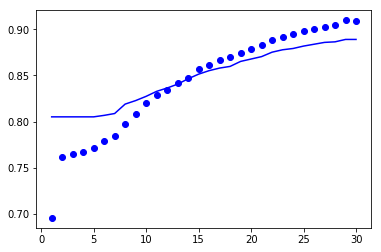

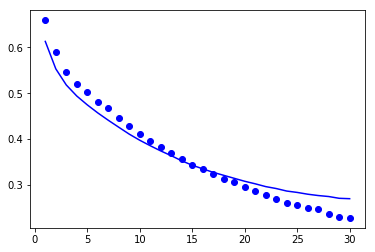

In [191]:
import matplotlib.pyplot as plt

print(list(history.history))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.show()

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [192]:
def build_test(text, types, power, toughness, colorless, multicolor, cmc):
    test = np.zeros( (1, inputs) )
    fill_data(test, 0, text, types, power, toughness, colorless, multicolor, cmc)
    return test

def predict(text, types, power, toughness, colorless, multicolor, cmc):
    colors = categories['colors']
    pr = model.predict(build_test(text, types, power, toughness, colorless, multicolor, cmc))[0]
    pr = [(colors[i], float(pr[i])) for i in range(len(colors))]
    pr.sort(key=lambda p:-p[1])
    pr = map(lambda p: (p[0], '%0.1f%%' % (100*p[1])), pr)
    return list(pr)


(1) What is the most appropriate color for this card?

Scrappy Survivor

[converted mana cost (CMC): 6]

Creature --

5/5

Menace, prowess

In [193]:
predict(["menace", "prowess"], ["Creature"], "5", "5", 0, 0, 6)

[('Red', '58.7%'),
 ('Blue', '11.2%'),
 ('Black', '9.1%'),
 ('White', '8.5%'),
 ('Green', '6.5%')]

(4) What is the most appropriate color combination for this multicolor card?

Come Work for Me Temporarily

[CMC: 4]

Sorcery

Gain control of target creature until end of turn. Untap it. It gets +1/+1 and gains haste, hexproof, and trample until end of turn.

In [194]:
predict(["gain", "control", "of", "target", "creature", "until", "end", "of", "turn", "untap", "it", 
           "it", "gets", "+1/+1", "and", "gains", "haste", "and", "trample", "until", "end", "of", "turn"],
        ["Sorcery"], "", "", 0, 1, 2)

[('Red', '14.1%'),
 ('Green', '4.9%'),
 ('White', '0.9%'),
 ('Black', '0.4%'),
 ('Blue', '0.1%')]

(15) If this card was a hybrid creature, what colors would it be?

Mysterio

[CMC: 4]

\*/\*

Flash

CARDNAME's power and toughness are each equal to the number of cards in your hand.

In [208]:
predict(cleanup("flash CARDNAME's power and toughness are each equal to the number of cards in your hand."),
       ["Creature"], "*", "*", 0, 1, 4)

[('Green', '6.2%'),
 ('Black', '5.2%'),
 ('White', '1.7%'),
 ('Blue', '1.0%'),
 ('Red', '0.5%')]

(28) We try to avoid making two-color cards where the card could be done as a monocolor card in one of the two colors. Given that, suppose you have a two-color 4/4 creature with flying and vigilance (and no other abilities). Which of the following color combinations would be the best choice for this card?

In [196]:
# Here it fails because it can't predict by ignoring monocolored cards with those keywords
predict(["flying", "vigilance"], ["Creature"], "4", "4", 0, 1, 4)

[('White', '13.9%'),
 ('Red', '3.0%'),
 ('Blue', '2.7%'),
 ('Black', '2.5%'),
 ('Green', '1.5%')]

(51) What are the most appropriate colors for this card?

Junkpile Engineer

[CMC: 3]

Creature -- Human Artificer

3/2

2, Sacrifice an artifact: Look at the top X cards of your library, where X is the converted mana cost of the sacrificed artifact. Put one of them into your hand and the rest on the bottom of your library in a random order.

In [203]:
predict(cleanup("2, Sacrifice an artifact: Look at the top X cards of your library, where X is the converted mana cost of the sacrificed artifact. Put one of them into your hand and the rest on the bottom of your library in a random order."),
        ["Creature"], "3", "2", 0, 1, 3)

[('Blue', '6.5%'),
 ('Red', '5.0%'),
 ('Black', '1.8%'),
 ('White', '0.3%'),
 ('Green', '0.2%')]

(54) What are the most appropriate colors for this card?

Dead Man Walking

[CMC: 7]

Creature -- Shapeshifter Wizard

1/1

When CARDNAME enters the battlefield, return target creature card from any graveyard to the battlefield under your control. All your creatures then become copies of that creature.

In [214]:
predict(cleanup("When CARDNAME enters the battlefield, return target creature card from any graveyard to the battlefield under your control. All your creatures then become copies of that creature."),
        ["Creature"], "1", "1", 0, 1, 7)

[('White', '5.8%'),
 ('Black', '3.8%'),
 ('Green', '1.6%'),
 ('Blue', '0.8%'),
 ('Red', '0.5%')]